In [7]:
import numpy as np
import random
from PIL import Image
import depth_pro
import matplotlib
import matplotlib.pyplot as plt
import pyvista as pv

In [34]:
# Load model and preprocessing transform
model, transform = depth_pro.create_model_and_transforms()
model.eval()

# Load and preprocess an image.
image_path = "../../../test_images/forest_with_road.jpeg"
#image_path = "../../../test_images/dark_and_light_forest.jpeg"
image, _, f_px = depth_pro.load_rgb(image_path)
image = transform(image)

# Run inference.
prediction = model.infer(image, f_px=f_px)
depth = prediction["depth"]  # Depth in [m].
focallength_px = prediction["focallength_px"]  # Focal length in pixels.

torch.Size([142, 355])


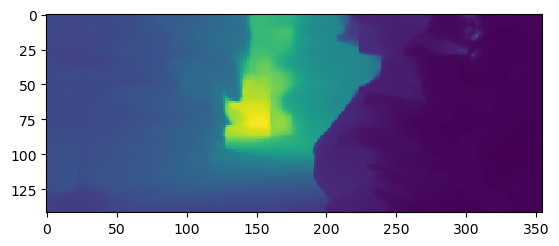

In [35]:
print(depth.shape)
from matplotlib import pyplot as plt
plt.imshow(depth, interpolation='nearest')
plt.show()

(142, 355, 3)


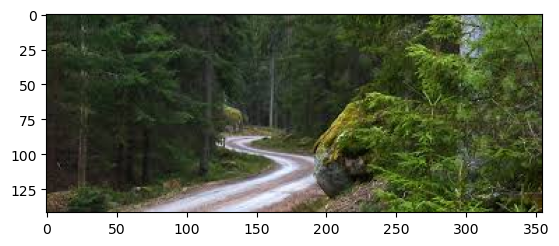

In [36]:
img = Image.open(image_path)
np_img = np.asarray(img)
print(np_img.shape)
plt.imshow(np_img)
plt.show()

In [51]:
pv.set_plot_theme("document")

# Create a new camera
camera = pv.Camera()
near_range = 0.6
far_range = 1.2
camera.clipping_range = (near_range, far_range)

# Set the position of the drawn camera
camera.position = (1, 0, 0)  # Change this to the desired position
camera.focal_point = (0, 0, 0)  # The point the camera is looking at

# Calculate direction
unit_vector = np.array(camera.direction) / np.linalg.norm(
    np.array([camera.focal_point]) - np.array([camera.position])
)

# Create frustum for the drawn camera
frustum = camera.view_frustum(1.0)

position = camera.position
focal_point = camera.focal_point
line = pv.Line(position, focal_point)


# Initialize the plotter
pl = pv.Plotter()
pl.add_text("3D projection")
pl.add_mesh(frustum, style="wireframe")  # Draw the frustum of the camera
pl.add_mesh(line, color="b")            # Draw a line from the camera to the focal point
pl.add_point_labels(
    [
        position,
        #camera.position + unit_vector * near_range,
        #camera.position + unit_vector * far_range,
        #focal_point,
    ],
    ["Camera Position"],#, "Near Clipping Plane", "Far Clipping Plane", "Focal Point"],
    margin=0,
    fill_shape=False,
    font_size=14,
    shape_color="white",
    point_color="red",
    text_color="black",
)

# Change the viewing camera (the camera you use to view the scene)
pl.camera.position = (1, 1, 1)
pl.camera.focal_point = (0, 0, 0)
pl.camera.up = (0.0, 0.0, 1.0)
pl.camera.zoom(0.5)
pl.add_arrows(np.array([1,0,0]),np.array([-1,0,0]), mag=0.2)

# ----------------------------------------

# Create plane of the image
camera_center=np.array([1,0,0])
focal_point=np.array([0,0,0])
v=focal_point-camera_center # direction vector
v_norm=v/np.linalg.norm(v)
distance=near_range
Pc = camera_center + distance*v_norm # Intersect point with plane of image

# Create image plane and parametrize the plane using the two basis vectors
w = np.array([1, 0, 0]) if v_norm[0] == 0 and v_norm[1] == 0 else np.array([0, 0, 1])
u1 = np.cross(v_norm, w)
u1 /= np.linalg.norm(u1)
u2 = np.cross(v_norm, u1)
u2 /= np.linalg.norm(u2)

# Generate points on the image plane
n_points_h = depth.shape[0]
n_points_w = depth.shape[1]
d=0.001
dist_w=  depth.shape[1]*d
dist_h= depth.shape[0]*d
alphas = np.linspace(-dist_w, dist_w, n_points_w)  # Parameter for u1
betas = np.linspace(-dist_h, dist_h, n_points_h)   # Parameter for u2
alpha_grid, beta_grid = np.meshgrid(alphas, betas)
plane_points = Pc + np.outer(alpha_grid.ravel(), u1) + np.outer(beta_grid.ravel(), u2)
np_plane_points=np.array(plane_points)

# Create vectors from camera center through generated "pixel"
camera_center_repeated = np.tile(camera_center, (np_plane_points.shape[0], 1))
vectors_to_plane = np_plane_points - camera_center_repeated
vector_magnitudes = np.linalg.norm(vectors_to_plane, axis=1, keepdims=True)  # Compute magnitudes
normalized_vectors = vectors_to_plane / vector_magnitudes

# Scale vectors with predicted depth
desired_length = np.array(depth).reshape(depth.shape[1] * depth.shape[0], 1)
points_at_distance = camera_center + normalized_vectors * desired_length

# Visilize the points
np_img_flat=np.array(np_img).reshape(depth.shape[1] * depth.shape[0], 3)
pl.add_points(points_at_distance, scalars=np_img_flat, render_points_as_spheres=True, rgb=True, point_size=5)
#pl.add_points(np_plane_points, color="blue", render_points_as_spheres=True, point_size=5)
pl.remove_scalar_bar()
pl.show()


Widget(value='<iframe src="http://localhost:33405/index.html?ui=P_0x7b07146f6520_38&reconnect=auto" class="pyv…